In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import adabound # https://github.com/Luolc/AdaBound
from torchsummary import summary
import sys

from torch.utils.tensorboard import SummaryWriter

# For notificaiton
import AppKit

# CNN - CIFAR-10

Files already downloaded and verified
Files already downloaded and verified


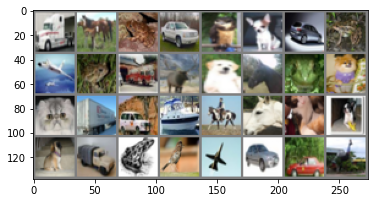

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 100
batch_size = 32
learning_rate = 0.005
log_directory = f"runs/CIFAR10/v1.2.0 AdaBound lr = {learning_rate}, epochs = {num_epochs}, batchsize ={batch_size}"
writer1  = SummaryWriter(log_directory)
#writer2 = SummaryWriter(log_directory)

# Loading dataset
# Since the dataset is in PIL (Python Imaging Library) form, tranform them into tensors of normalised range [-1, 1]
transform = transforms.Compose( # this transforms.compose combines multiple tranformations as one
    [
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

# The CIFAR10 tataset is avaliable in PyTorch
train_dataset = torchvision.datasets.CIFAR10(root='./cifar10Dataset', train=True,  download=True, transform=transform)
test_dataset  = torchvision.datasets.CIFAR10(root='./cifar10Dataset', train=False, download=True, transform=transform)

# Splitting the training and testing datasets into smaller batches
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)

classes = ('Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

# Checking a data sample 
example = iter(train_loader)
images, labels = example.next()

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Feature extraction layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)      # Input 3 (RGB), 6 (outputs), 5 (kernel size)
        self.pool  = nn.MaxPool2d(2, 2)      # Kernel size of 2 with stride of 2
        self.conv2 = nn.Conv2d(6, 16, 5)     # Input 6 (conv1's output), 16 (outputs), 5 (kernel size)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)    # Input 16 (conv1's output), 32 (outputs), 5 (kernel size)
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)    # Input 32 (conv1's output), 64 (outputs), 3 (kernel size)
        # Classification layers
        self.fc1   = nn.Linear(64*5*5, 120)   # Fully connected linear layer. 16 is the output of conv2 and 5x5 is
#                                             the output dimention after conv1->pool->conv2->pool. 
#                                             The process can be observed in the coming cells.
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)        # Output is 10 as we have 10 classes in the CIFAR-10 dataset

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, 64*5*5) # Flattening x. # -1 makes pytorch infer the dimensionality, which in this case is the number of batches (4).
# It does this by looking at the given dimentions, and inferring the last one using the amount of avaliable data/cells.
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)         # Don't apply softmax, as it's applied in the used criterion - nn.CrossEntropyLoss()
        return x
        
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
#optimiser = torch.optim.SGD(model.parameters(), lr=larning_rate)
optimiser = adabound.AdaBound(model.parameters(), lr=1e-6, final_lr=learning_rate) # try adam
#scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=num_epochs, gamma=0.1)

# Tensorboard
writer1.add_graph(model, images)
writer1.close()

# Doing the training now
n_total_steps = len(train_loader)

running_loss = 0
running_correct = 0
running_loss_test = 0

x = 1
steps_until_print = batch_size #(len(train_dataset))/x           # Log once per epoch/x
#print(f'One batch has {len(example)/batch_size} images\nPrint every {steps_until_print}')

for epoch in range(num_epochs):

    testing_batches = iter(test_loader) # For every epoch, we want to have tested the whole testing dataset once

    for i, (images, labels) in enumerate(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimiser.zero_grad()   # Clear old gradient values
        loss.backward()         # Calculate the gradients
        optimiser.step()        # Update the model's weights (these are the model parameters(), different from hyperparameters)

        with torch.no_grad():
            # Add loss to the running loss 
            running_loss = loss.item()
            _, predictions = torch.max(outputs, 1)                  # Evaluate along the 1st dimension

            running_correct = (predictions == labels).sum().item()  # We can call .item() as it's a tensor with one item

            if (i+1) % steps_until_print == 0:
                # Logging the loss
                writer1.add_scalar('Loss/training', (running_loss/steps_until_print)/batch_size, epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step 
                # Adding the accuracy
                writer1.add_scalar('Accuracy/training', (running_correct/batch_size*100/batch_size), epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step 
                #running_loss = 0.0
                #running_correct = 0

            # If for every 5 epochs, test one batch. (test:train data ratio is split 1:5)
            if (i+1) % 5 == 0:  # Logging the testing loss
                test_images, test_labels = testing_batches.next()
                
                test_images = test_images.to(device)
                test_labels = test_labels.to(device)

                test_outputs = model(test_images)

                _, test_predictions = torch.max(test_outputs, 1)
                test_running_correct = (test_predictions == test_labels).sum().item()
                writer1.add_scalar('Accuracy/testing', test_running_correct/batch_size*100, epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step 

                test_loss = criterion(test_outputs, test_labels)
                test_running_loss = test_loss.item()
                writer1.add_scalar('Loss/testing', test_running_loss/len(test_labels), epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step

    #writer2.add_scalar('Loss/training', running_loss/steps_until_print, epoch * n_total_steps) # label of the scalar, actual loss mean, current global step
    #print(f'Epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.5f}, testing loss = {running_loss_test}')
    print(f'Epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.5f}')

    #print(f'Finished epoch {epoch+1}/{num_epochs}')
    #scheduler.step()

print("Training is done")
AppKit.NSBeep()

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch/lib/python3.8/site-packages/adabound/adabound.py:94: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


Epoch 1/100, step 1563/1563, loss = 2.30216
Epoch 2/100, step 1563/1563, loss = 2.30103
Epoch 3/100, step 1563/1563, loss = 2.18300
Epoch 4/100, step 1563/1563, loss = 2.35955
Epoch 5/100, step 1563/1563, loss = 1.66255
Epoch 6/100, step 1563/1563, loss = 1.62042
Epoch 7/100, step 1563/1563, loss = 1.55348
Epoch 8/100, step 1563/1563, loss = 1.60693
Epoch 9/100, step 1563/1563, loss = 1.51603
Epoch 10/100, step 1563/1563, loss = 1.90141
Epoch 11/100, step 1563/1563, loss = 1.92798
Epoch 12/100, step 1563/1563, loss = 1.00643
Epoch 13/100, step 1563/1563, loss = 1.48374
Epoch 14/100, step 1563/1563, loss = 1.48026
Epoch 15/100, step 1563/1563, loss = 1.55188
Epoch 16/100, step 1563/1563, loss = 0.75446
Epoch 17/100, step 1563/1563, loss = 1.28665
Epoch 18/100, step 1563/1563, loss = 1.23787
Epoch 19/100, step 1563/1563, loss = 1.35617
Epoch 20/100, step 1563/1563, loss = 1.22911
Epoch 21/100, step 1563/1563, loss = 1.18210
Epoch 22/100, step 1563/1563, loss = 1.22813
Epoch 23/100, step 

KeyboardInterrupt: 

# Why 16\*5\*5 in fc1? 
![](.md_images/2022-02-15-15-26-53.png)

In [ ]:
def output_dimentions(W, F, P, S): # To read more, look at "Calculating the output dimentions" in the HackMD: https://hackmd.io/@6GXCH802RhyTNfXCGTWmOA/BJC32s5RK
#   W = input size, F = filter/kernel size, P = padding, S = stride
    return (W-F+2*P)/S + 1

# self.conv3 = nn.Conv2d(16, 32, 3)    # Input 6 (conv1's output), 32 (outputs), 3 (kernel size)

# After conv1
output_dimentions(W=32, F=5, P=0, S=1) # Will have 6 outputs

28.0

In [ ]:
# After pool
output_dimentions(W=28, F=2, P=0, S=2) # Will have 6 outputs

14.0

In [ ]:
# After conv2
output_dimentions(W=14, F=5, P=0, S=1) # Will have 16 outputs

10.0

In [ ]:
# After pool again
output_dimentions(W=10, F=2, P=0, S=2) # Will have 16 outputs

5.0

In [ ]:
# After conv3
output_dimentions(W=5, F=5, P=2, S=1) # Will have 32 outputs

5.0

In [ ]:
# After conv4
output_dimentions(W=5, F=3, P=1, S=1) # Will have 64 outputs

5.0

In [6]:
# Network size

summary(model, (3, 32, 32))

# Validation
model.eval()
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        _, predictions = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()

    accuracy = 100 * n_correct / n_samples
    print(f"Accuracy = {accuracy}")
model.train()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Conv2d-5             [-1, 32, 5, 5]          12,832
            Conv2d-6             [-1, 64, 5, 5]          18,496
            Linear-7                  [-1, 120]         192,120
            Linear-8                   [-1, 84]          10,164
            Linear-9                   [-1, 10]             850
Total params: 237,334
Trainable params: 237,334
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.08
Params size (MB): 0.91
Estimated Total Size (MB): 1.00
-------------------------------------------

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [8]:
# Detailed validation - accuracy for each class

model.eval() # Disables zeroed out neurons for better evaluation instead of training

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        _, predictions = torch.max(outputs, 1)  # torch.max returns (value, index)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i]
            pred = predictions[i]
            if(pred == label):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    accuracy = 100 * n_correct / n_samples
    print(f"General network accuracy = {accuracy}")

    for i in range(10):
        accuracy = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'{classes[i]} class accuracy: \t \t {accuracy}%')

model.train()



General network accuracy = 66.61
Plane class accuracy: 	 	 69.8%
Car class accuracy: 	 	 79.5%
Bird class accuracy: 	 	 60.2%
Cat class accuracy: 	 	 39.5%
Deer class accuracy: 	 	 60.3%
Dog class accuracy: 	 	 58.0%
Frog class accuracy: 	 	 74.2%
Horse class accuracy: 	 	 72.4%
Ship class accuracy: 	 	 80.7%
Truck class accuracy: 	 	 71.5%


ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)